In [24]:
from math import *
from pylab import *

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import time

import redpitaya_scpi as scpi

### 1. Calculations

In [25]:
BITS_PER_SAMPLE = 32        # bits
SAMPLE_RATE     = 125e6     # Hz

UNITS = 'RAW'
# UNITS = 'VOLTS'

In [26]:
maxMemBytes = 16**5 * 2

maxNumMemSamples = maxMemBytes * 8 / BITS_PER_SAMPLE
# maxNumMemSamples = 2**14      # 16384

print('Per channel:')
print('Max memory allocated  = {:>8} = 16^{:<2} bytes'.format(int(maxMemBytes), log2(maxMemBytes)/log2(16)))
print('Max number of samples = {:>8} =  2^{:<2}'.format(int(maxNumMemSamples), log2(maxNumMemSamples)))

Per channel:
Max memory allocated  =  2097152 = 16^5.25 bytes
Max number of samples =   524288 =  2^19.0


In [27]:
signalPeriod = maxNumMemSamples / SAMPLE_RATE
signalFrequency = 1 / signalPeriod

print('Singal period   = {:>10.5f} μs'.format(signalPeriod * 1e6))
print('Signal frequncy = {:>10.5f} Hz'.format(signalFrequency))

Singal period   = 4194.30400 μs
Signal frequncy =  238.41858 Hz


### 2. Deep Memory Acquisition via SCPI Server

In [28]:
## CONNECTION
IP = '192.168.234.234'      # local IP of Red Pitaya
rp_s = scpi.scpi(IP)        # open socket connection with Red Pitaya

## RESET ACQUISITION
rp_s.tx_txt('ACQ:RST')

In [29]:
## CONFIGURATION

## number of samples (per channel) to write/read
DATA_SIZE = maxNumMemSamples
READ_DATA_SIZE  = maxNumMemSamples

## signal units
units = UNITS

## decimation
dec = 1

## trigger
# trig_lvl = 0
trig_src = 'NOW'
# trig_src = 'CH1_PE'
# trig_src = 'CH2_PE'

In [30]:
# get memory region
size = int(rp_s.txrx_txt('ACQ:AXI:SIZE?'))
start_address_a = int(rp_s.txrx_txt('ACQ:AXI:START?'))
start_address_b = round(start_address_a + size/2)

print('Net size of memory region  = 0x{:07X} bytes'.format(size))
print('Start address Channel A    = 0x{:07X}'.format(start_address_a))
print('Start address Channel B    = 0x{:07X}'.format(start_address_b))

Net size of memory region  = 0x0400000 bytes
Start address Channel A    = 0x1000000
Start address Channel B    = 0x1200000


In [31]:
# set decimatin
rp_s.tx_txt(f'ACQ:AXI:DEC {dec}')

# set units
rp_s.tx_txt(f'ACQ:AXI:DATA:UNITS {units}')

# set trigger delay for both channels
rp_s.tx_txt(f'ACQ:AXI:SOUR1:Trig:Dly {DATA_SIZE}')
rp_s.tx_txt(f'ACQ:AXI:SOUR2:Trig:Dly {DATA_SIZE}')

# set DMA buffer address and size in bytes
rp_s.tx_txt(f'ACQ:AXI:SOUR1:SET:Buffer {start_address_a},{size/2}')
rp_s.tx_txt(f'ACQ:AXI:SOUR2:SET:Buffer {start_address_b},{size/2}')

# enable DMA
rp_s.tx_txt('ACQ:AXI:SOUR1:ENable ON')
rp_s.tx_txt('ACQ:AXI:SOUR2:ENable ON')
print('Channel A and Channel B are enabled')

# set acquisition trigger
# rp_s.tx_txt(f'ACQ:TRig:LEV {trig_lvl}')

Channel A and Channel B are enabled


In [32]:
## ACQUISITION

rp_s.tx_txt('ACQ:START')
print('Acquisition started')

# set trigger source
rp_s.tx_txt(f'ACQ:TRig {trig_src}')

# wait for trigger
while 1:
    rp_s.tx_txt('ACQ:TRig:STAT?')
    if rp_s.rx_txt() == 'TD':       # 'TD' or 'WAIT'
        print('Triggered')
        time.sleep(1)
        break

# wait until adc buffer is filled
while 1:
    rp_s.tx_txt('ACQ:AXI:SOUR1:TRIG:FILL?')
    is_full_1 = rp_s.rx_txt()

    rp_s.tx_txt('ACQ:AXI:SOUR2:TRIG:FILL?')
    is_full_2 = rp_s.rx_txt()

    if is_full_1 == '1' or is_full_2 == '1':
        if is_full_1 == '1':
            print('DMA buffer 1 full')
        if is_full_2 == '1':
            print('DMA buffer 2 full')
        break

# stop acquisition
rp_s.tx_txt('ACQ:STOP')
print('Acquisition stopped')

Acquisition started
Triggered
DMA buffer 1 full
DMA buffer 2 full
Acquisition stopped


In [33]:
## GET WRITE POINTERS

posChA = int(rp_s.txrx_txt('ACQ:AXI:SOUR1:Trig:Pos?'))
posChB = int(rp_s.txrx_txt('ACQ:AXI:SOUR2:Trig:Pos?'))

print('Write pointers (at trigger locations):')
print('Channel A = 0x{:07X}'.format(posChA))
print('Channel B = 0x{:07X}'.format(posChB))

Write pointers (at trigger locations):
Channel A = 0x0013385
Channel B = 0x0013385


In [34]:
## READ & PROCESS DATA

rp_s.tx_txt(f'ACQ:AXI:SOUR1:DATA:Start:N? {posChA},{READ_DATA_SIZE}')
signal_str_a = rp_s.rx_txt()

rp_s.tx_txt(f'ACQ:AXI:SOUR2:DATA:Start:N? {posChB},{READ_DATA_SIZE}')
signal_str_b = rp_s.rx_txt()

signal_num_a = signal_str_a.strip('{}\n\r').replace('  ', '').split(',')
signal_num_b = signal_str_b.strip('{}\n\r').replace('  ', '').split(',')

units_data_type = int if units == 'RAW' else float

signal_num_a = list(map(units_data_type, signal_num_a))
signal_num_b = list(map(units_data_type, signal_num_b))

# convert from lists to numpy arrays
signal_num_a = np.array(signal_num_a)
signal_num_b = np.array(signal_num_b)

print('Data read and processed')

Data read and processed


In [35]:
## SAVE DATA

dataFileName = f'noise_{int(READ_DATA_SIZE)}_{int(SAMPLE_RATE/1e6)}MHz_{units.lower()}'

np.save(f'{dataFileName}_chA.npy', signal_num_a)
np.save(f'{dataFileName}_chB.npy', signal_num_b)

In [36]:
## RELEASE RESOURCES & SEVER CONNECTION

rp_s.tx_txt('ACQ:AXI:SOUR1:ENable OFF')
rp_s.tx_txt('ACQ:AXI:SOUR2:ENable OFF')
rp_s.close()

print('Resources released')

Resources released


### 3. Data Analysis

In [37]:
## LOAD .npy DATA FILES

nSamples = maxNumMemSamples

units = 'RAW'
# units = 'VOLTS'
# units = UNITS

# dataDate = '2024_07_23_4/'
dataDate = ''

filename = f'{dataDate}noise_{int(nSamples)}_{int(SAMPLE_RATE/1e6)}MHz_{units.lower()}'

signal_num_a = np.load(f'{filename}_chA.npy')
signal_num_b = np.load(f'{filename}_chB.npy')

print(f'{filename} data loaded into Numpy arrays')

noise_524288_125MHz_raw data loaded into Numpy arrays


In [38]:
# data properties
nSamples = len(signal_num_a)
tSamples = (nSamples / SAMPLE_RATE)     # sampling time (in seconds)

t = np.linspace(0, tSamples, nSamples)

#### 3.1 Noise Distribution

In [39]:
## CONFIGURATION

R = 50  # resistance (in Ohms)

nBins = 11
density = True

signal_num = signal_num_a
signal_num_label = 'Channel A'

In [40]:
# set units for plotting
units_plot = ''
if units == 'VOLTS':
    signal_num *= 1e3
    units_plot = 'mV'
elif units == 'RAW':
    units_plot = 'bits'

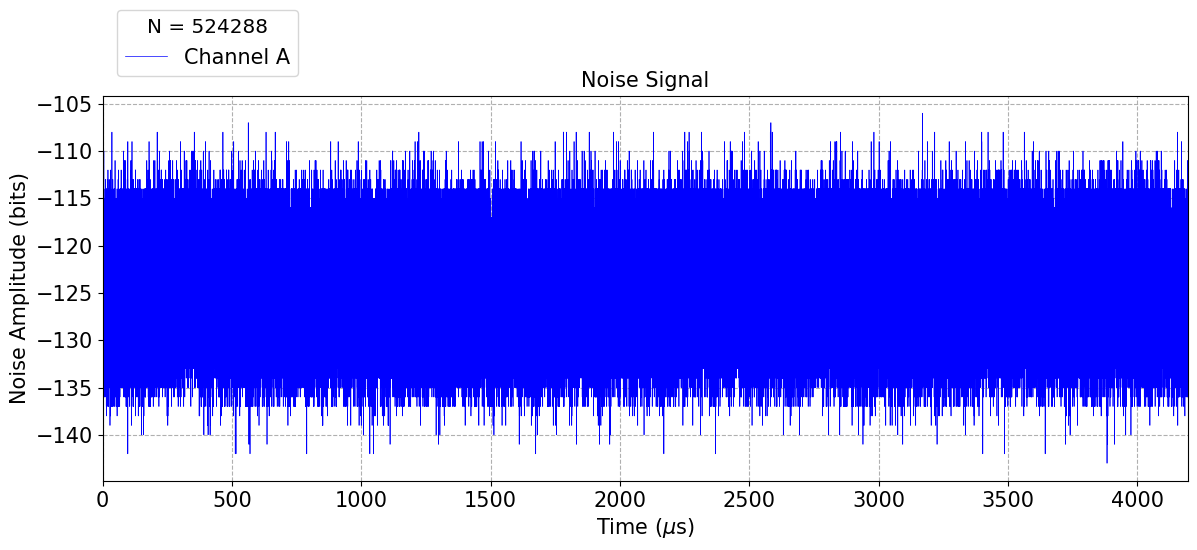

In [41]:
plt.figure(figsize=(14, 5))

plt.plot(t*1e6, signal_num, '-b', lw=0.5, label=signal_num_label)

plt.title('Noise Signal', fontsize=15)
plt.xlabel(r'Time ($\mu$s)', fontsize=15)
plt.ylabel(f'Noise Amplitude ({units_plot})', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim([0, t[-1]*1e6])

# if units == 'VOLTS':
#     plt.ylim(-5, 5)

legendTitle = 'N = {}'.format(nSamples)
plt.legend(title=legendTitle, title_fontsize='x-large', prop={'size': 15},
        bbox_to_anchor=(0.19, 1.25))

plt.grid(ls='--')
plt.show()

In [42]:
bins_range = np.arange(min(signal_num)-0.5, max(signal_num)+0.5, 1)

In [43]:
# calculate histogram
if units == 'VOLTS':
    hist, bins = np.histogram(signal_num, bins=nBins, density=density)
elif units == 'RAW':
    hist, bins = np.histogram(signal_num, bins=bins_range, density=density)

bin_centers = (bins[1:] + bins[:-1]) * 0.5

# fit Gaussian
mu, sigma = sp.stats.norm.fit(signal_num)
x = np.linspace(bin_centers[0], bin_centers[-1], 100)
p = sp.stats.norm.pdf(x, mu, sigma)

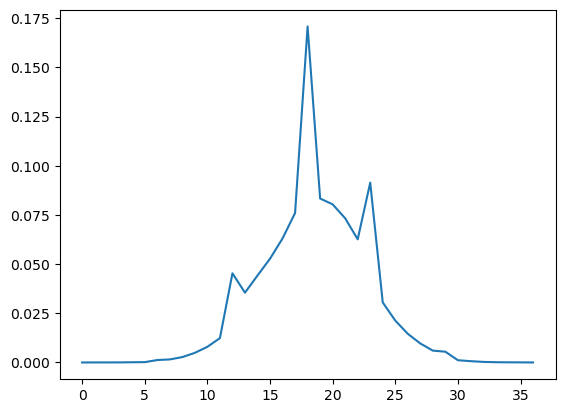

In [44]:
plt.plot(hist)

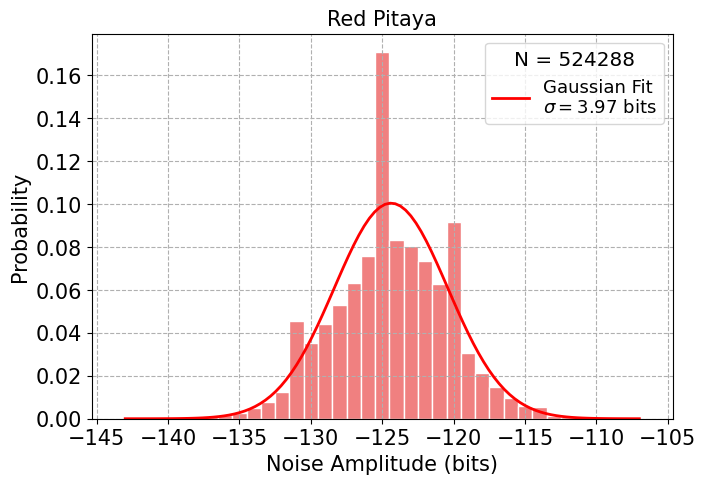

In [45]:
plt.figure(figsize=(7.5, 5))

if units == 'VOLTS':
    plt.hist(signal_num, bins=nBins, density=density, color='seagreen', edgecolor='w')    
elif units == 'RAW':
    plt.hist(signal_num, bins=bins_range, density=density, color='lightcoral', edgecolor='w')

plt.plot(x, p, '-r', lw=2, label='Gaussian Fit\n'+rf'$\sigma = {sigma:.2f}$ {units_plot}')

plt.title('Red Pitaya', fontsize=15)
plt.xlabel(f'Noise Amplitude ({units_plot})', fontsize=15)
plt.ylabel('Probability', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

legendTitle = 'N = {}'.format(nSamples)
plt.legend(title=legendTitle, loc='best', title_fontsize='x-large', prop={'size': 13})

plt.grid(ls='--')
plt.show()

#### 3.2. Fast Fourier Transform

In [46]:
if units == 'RAW' :
    raise SystemExit("Stopped here")

SystemExit: Stopped here

In [ ]:
# convert signal back to V from mV
signal_num /= 1e3

In [ ]:
# calculate FFT frequency
t_fftfreq = np.fft.fftfreq(nSamples, 1/SAMPLE_RATE)
t_fftfreq_nyq = t_fftfreq[:nSamples // 2]

3.2.2 Spectrum in dBV

In [ ]:
signal_num_fft = np.fft.fft(signal_num)
signal_num_fft_nyq = np.abs(signal_num_fft[:nSamples // 2])
signal_num_fft_nyq_db = 10*np.log10(signal_num_fft_nyq)

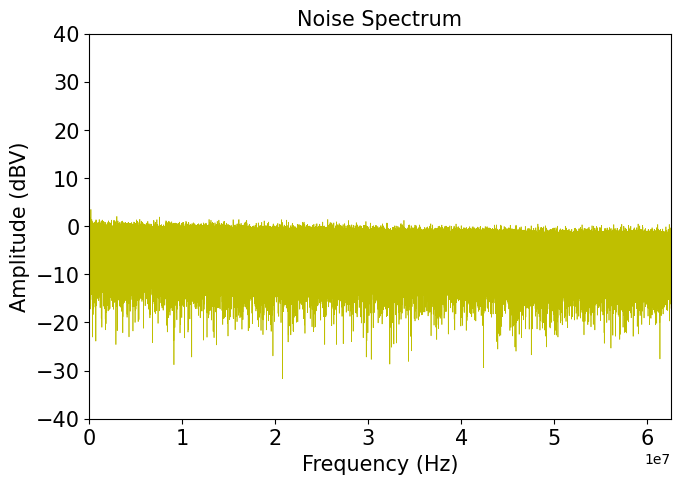

In [ ]:
plt.figure(figsize=(7.5, 5))

plt.plot(t_fftfreq_nyq, signal_num_fft_nyq_db, '-y', lw=0.5, label='Channel A')

plt.title('Noise Spectrum', fontsize=15)
plt.xlabel('Frequency (Hz)', fontsize=15)
plt.ylabel(f'Amplitude (dBV)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlim(min(t_fftfreq_nyq), max(t_fftfreq_nyq))
plt.ylim(-40, 40)

# legendTitle = 'N = {}'.format(nSamples)
# plt.legend(title=legendTitle, loc='best', title_fontsize='x-large', prop={'size': 15})

# plt.grid(ls='--')
plt.show()

3.2.2 Spectrum in dBm

In [ ]:
signal_num_fft = signal_num_fft**2 / R
signal_num_fft_nyq = np.abs(signal_num_fft[:nSamples // 2])
signal_num_fft_nyq_db = 10*np.log10(signal_num_fft_nyq)

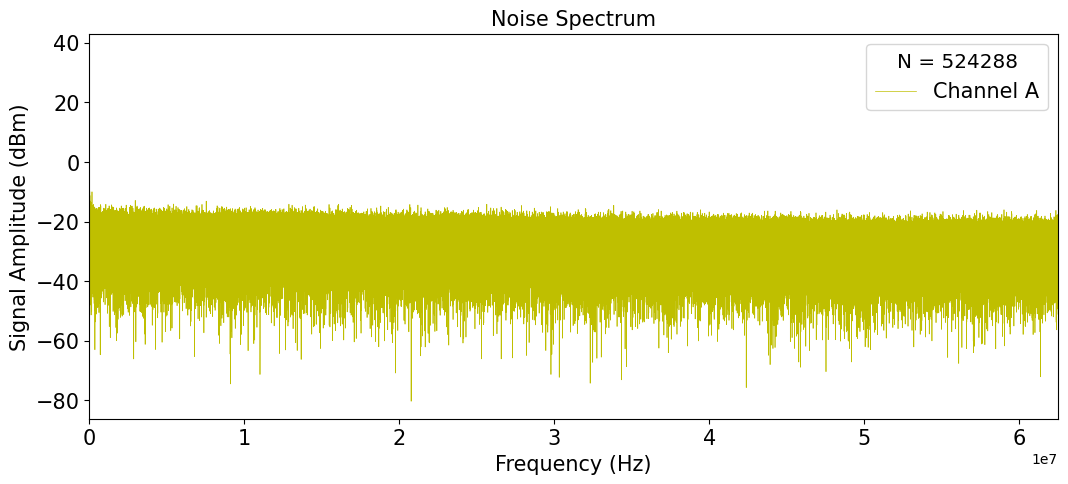

In [ ]:
plt.figure(figsize=(12.5, 5))

plt.plot(t_fftfreq_nyq, signal_num_fft_nyq_db, '-y', lw=0.5, label='Channel A')

plt.title('Noise Spectrum', fontsize=15)
plt.xlabel('Frequency (Hz)', fontsize=15)
plt.ylabel(f'Signal Amplitude (dBm)', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

plt.xlim(min(t_fftfreq_nyq), max(t_fftfreq_nyq))

legendTitle = 'N = {}'.format(nSamples)
plt.legend(title=legendTitle, loc='best', title_fontsize='x-large', prop={'size': 15})

plt.show()